<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/CNN_for_new_data_no_hidden_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  # previous version, with hidden code and comments - cnn_scorer_not_working

from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function


**CNNy dla nowych danych:**

* jako testowe mamy te co wcześniej nagrania (6 nagrań z 2016), podzielone na 0,5sek fragmenty, z overlapem 150 ms bodajże. Całe nagrania podzielone, więc bardzo mało próbek pozytywnych będzie. 2,2% z głosami (676 bezwzględnie), sumarycznie 30813 rekordów
* jako trening - zbalansowany zbiór ~45 nagrań półgodzinnych. Nie jest idealnie 50:50, bo jeśli było w półgodzinnym nagraniu mniej niż 50 ramek z głosami (albo wcale), to i tak dokładałam 50 losowych ramek bez głosów (jest 45:55). Sumarycznie 17293 rekordów. 
* Na razie testowana reprezentacja 3 - mel spektrogram z pipeline'a birdvoxa - projektu o nocnych migrantach w hameryce. wygląda że działa?



**Pytania:**
* używam ważenia c_w = { 0:0.01, 1:0.99} - ma to sens? Karanie za 0, nagradzanie za 1
* po 50 epokach, model niezmieniany względem prób sprzed pół roku, AUC wychodzi rzędu 94-97% - jak to?... I nie wychodzą same zera, wręcz przeciwnie. Jest tu jakiś błąd czy po prostu jakimś cudem to po prostu działa?
* Chyba wartoby zrobić więcej danych testowych? Może jakieś inne? Na razie są te, by można było porównać z tym wszystkim co było robione poprzednio.




In [0]:
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.utils import class_weight
from sklearn.metrics import  make_scorer
from sklearn.metrics import log_loss
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
import glob
import os
import random
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

1


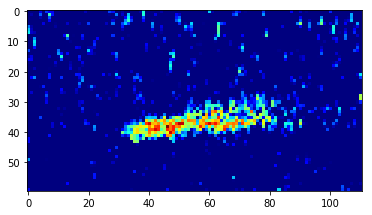

In [4]:
from numpy.random import seed
seed(667)
from tensorflow import set_random_seed
set_random_seed(667)
import random
random.seed()

## Reprezentacja 3 na razie sprawdzana  - czyli mel-spektrogram z birdvoxa, z zawężonym zakresem częstotliwości

X_train1 = numpy.load('drive/My Drive/repr7/X_train_rep3.npy', allow_pickle=True)
y_train1 = numpy.load('drive/My Drive/repr7/y_train.npy', allow_pickle=True)
X_test1 = numpy.load('drive/My Drive/repr7/X_test_rep3.npy', allow_pickle=True)
y_test1 = numpy.load('drive/My Drive/repr7/y_test.npy', allow_pickle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=667)
exemp = 4# exemplary frame
plt.imshow(X_val[exemp], cmap="jet")
print(y_val[exemp])
r = np.shape(X_val)[1]
s = np.shape(X_val)[2]

X_train = X_train.reshape(X_train.shape[0], 1, r, s).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 1, r, s).astype('float32')
X_test = X_test1.reshape(X_test1.shape[0], 1, r, s).astype('float32')
y_test = np.squeeze(y_test1)
input_shape = (1, r, s)


In [0]:
c_w = { 0:0.01, 1:0.99}# { 0:0.02, 1:0.98}  # tak było, jeśli w trening wrzucamy całe nagranie. teraz mamy zbalansowany zbiór
index = ['r%d' % x for x in range(len(y_train))]
a = [c_w[class_label] for class_label in y_train]
sample_weight_frame = pd.DataFrame(a, index = index)
score_params = {"sample_weight": sample_weight_frame}
#print(sample_weight_frame[0:5])


In [0]:
# https://github.com/keras-team/keras/issues/2115

### SCORERS
import tensorflow as tf
import functools
from functools import partial, update_wrapper

def my_score(y_true, y_pred, sample_weight): 
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)

def wrapped_partial(func, *args, **kwargs):
	partial_func = partial(func, *args, **kwargs)
	update_wrapper(partial_func, func)
	return partial_func

def binary_crossentropy_weigted(y_true, y_pred, class_weights):
	y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
	loss = K.mean(class_weights*(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)),axis=-1)
	return loss

my_scorer = make_scorer(my_score,greater_is_better=False, needs_threshold=False,**score_params)  ## scoring for gridsearchCV
custom_loss = wrapped_partial(binary_crossentropy_weigted, class_weights=np.array([0.02, 0.98])) ## scoring for model.compile


## AUC METRIC
def as_keras_metric(method):
    import functools
    from keras import backend as K
    
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
  
auc_roc = as_keras_metric(tf.metrics.auc)


**BUILDING THE MODEL**

In [0]:
def make_model_modified(): #(dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out):
  
    dense_layer_sizes=128
    filters=10
    kernel_size=(3,3) #(3,3)
    pool_size= (2,2) 
    lr=0.0001 
    drop_out = 0.5
        
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
   # model.add(Conv2D(16, (3, 3), input_shape=input_shape ))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    
    model.add(Flatten())
    model.add(Dense(dense_layer_sizes, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=custom_loss,#'binary_crossentropy',#loss_2_args(y_true, y_pred)'',#loss='binary_crossentropy'
                  # co tu powinno wejść? o samo co do scoring w GridSearchCv? chyba nie: https://stackoverflow.com/questions/40572743/scikit-learn-grid-search-own-scoring-object-syntax
                  # my_score2(sample_weight = sample_weight_frame), <------------------- nie umiem zrobić by działał tutaj. Która funkcja? my_score czy my_scorer ?
                  # my_score2(sample_weight_frame) ---->  https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred
                  # my_loss ---------------------------->też nie chodzi a chyba powinien, coś z formatem nie tak.  ERROR: 'Tensor' object has no attribute 'values'
                  # inne źródło: https://github.com/keras-team/keras/issues/2115
                  optimizer='adam',#keras.optimizers.Adam(lr),#'adam',
                  metrics=['accuracy',auc_roc])

    return model

**UKKYBIRDDET MODEL** // not here


**GRID SEARCH** // none here



**CALLBACKS** // costamcostam


In [8]:
# dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out)
#my_classifier2 = KerasClassifier(make_model_modified(128,10,(3,3),(2,2),0.001,0.5))

#################################

repr_nr = '_rep3_'  
my_model = make_model_modified() #make_model_ukybirddet()

#################################
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler, CSVLogger
import math
import datetime
now = datetime.datetime.now()
start_time = str(now.year)+str('-')+str(now.month)+str('-')+str(now.day)+str('_')+str(now.hour+2)+str(':')+str(now.minute)

'''
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 30.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	#print(lrate)
	return lrate

keras.callbacks.CSVLogger('', separator=',', append=False)

lrate = LearningRateScheduler(step_decay)
csv_logger = CSVLogger('drive/My Drive/przebiegi/training_150e_001_01_co30_3.log')
#es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, mode='max', baseline=None, restore_best_weights=True)
'''

y_frame = pd.DataFrame(y_train, index=index)

grid_result = my_model.fit(X_train, y_frame, batch_size = 32, epochs=100,validation_data=(X_val, y_val), verbose = 2) #, class_weight = c_w)


#grid_result = my_model.fit(X_train, y_frame, batch_size = 32, callbacks=[plot_losses, csv_logger, lrate, histories], epochs=150,validation_data=(X_val, y_val), verbose = 2) #, class_weight = c_w)
# [es, plot_losses, lrate, csv_logger, histories]
#my_model.save(('flmdl'+ repr_nr + start_time + '.h5'))
#print('Training done. The results are in : ')



W0619 13:46:08.216369 140251936130944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 13:46:08.219373 140251936130944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 13:46:08.224314 140251936130944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 13:46:08.241771 140251936130944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 13:46:08.242683 1402519361

Train on 13834 samples, validate on 3459 samples
Epoch 1/100
 - 6s - loss: 0.3379 - acc: 0.6800 - auc: 0.5787 - val_loss: 0.2071 - val_acc: 0.8375 - val_auc: 0.7408
Epoch 2/100
 - 3s - loss: 0.1875 - acc: 0.8541 - auc: 0.8016 - val_loss: 0.1604 - val_acc: 0.8771 - val_auc: 0.8392
Epoch 3/100
 - 3s - loss: 0.1600 - acc: 0.8791 - auc: 0.8594 - val_loss: 0.1526 - val_acc: 0.8768 - val_auc: 0.8734
Epoch 4/100
 - 3s - loss: 0.1479 - acc: 0.8896 - auc: 0.8832 - val_loss: 0.1394 - val_acc: 0.8997 - val_auc: 0.8914
Epoch 5/100
 - 3s - loss: 0.1426 - acc: 0.8942 - auc: 0.8975 - val_loss: 0.1428 - val_acc: 0.9023 - val_auc: 0.9023
Epoch 6/100
 - 3s - loss: 0.1357 - acc: 0.9039 - auc: 0.9063 - val_loss: 0.1334 - val_acc: 0.9046 - val_auc: 0.9102
Epoch 7/100
 - 3s - loss: 0.1301 - acc: 0.9053 - auc: 0.9132 - val_loss: 0.1371 - val_acc: 0.8965 - val_auc: 0.9160
Epoch 8/100
 - 3s - loss: 0.1231 - acc: 0.9111 - auc: 0.9186 - val_loss: 0.1321 - val_acc: 0.9112 - val_auc: 0.9209
Epoch 9/100
 - 3s - los

In [0]:
my_model.save(('drive/My Drive/models/flmdl'+ str(repr_nr) + str(start_time) + '.h5'))

CNN Error for val set: 9.89%
CNN Error for test set: 9.20%
(30813,)
(30813, 1)
AUC: 0.974


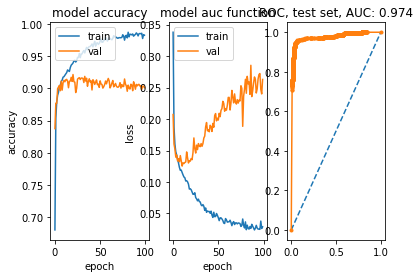

In [10]:
model = my_model
hist = grid_result
# Final evaluation of the model
scores_val = model.evaluate(X_val, y_val, verbose=0)
print("CNN Error for val set: %.2f%%" % (100-scores_val[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error for test set: %.2f%%" % (100-scores_test[1]*100))

# summarize history for accuracy
plt.subplot(1, 3, 1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1, 3, 2)

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model auc function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

# calculate AUC of final model on a test set
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = y_test  # osobno, bo inny wymiar
print(np.shape(y_test2))
print(np.shape(probs))

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
plt.subplot(1, 3, 3)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC, test set, AUC: %.3f' % auc)
pyplot.show()

(0.7, 1.05)

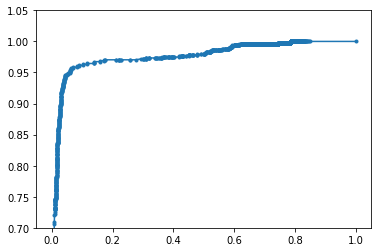

In [11]:
pyplot.plot(fpr, tpr, marker='.')
pyplot.ylim(bottom=0.7)


0.8198293
[[28334  1803]
 [   34   642]]
              precision    recall  f1-score   support

     class 0       1.00      0.94      0.97     30137
     class 1       0.26      0.95      0.41       676

    accuracy                           0.94     30813
   macro avg       0.63      0.94      0.69     30813
weighted avg       0.98      0.94      0.96     30813



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.59, F = 0.41')

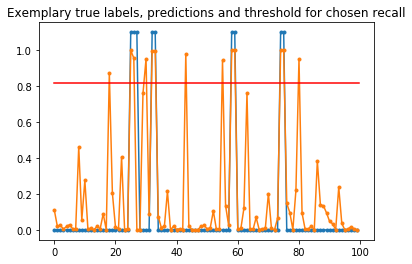

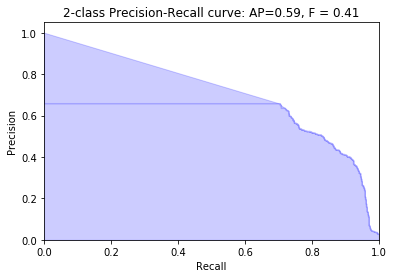

In [14]:
import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

start1 = 22800
end1 = 22900


index2 = ['r%d' % x for x in range(len(y_test))]
a2 = [c_w[class_label] for class_label in y_test]

#########
recall = 0.95
###########

a = (np.where(tpr>recall))
thr = thresholds[np.min(a)]  # do stworzenia confusion matrix bierzemy jakiś próg, np 90% wykrytych głosów
print(thr)
t2 = np.arange(0.0, end1-start1, 0.5)
plt.figure((1))
pyplot.plot(y_test2[start1:end1]*1.1, marker='.')
pyplot.plot(probs[start1:end1], marker='.')
pyplot.plot(t2, thr* np.ones(np.size(t2)), 'r-')
pyplot.title('Exemplary true labels, predictions and threshold for chosen recall')

probs_bool = probs>thr
probs_01 = [int(elem) for elem in probs>thr]
#cm = sklearn.metrics.confusion_matrix(y_test2, probs_01, labels=None, sample_weight=a2).ravel()
sklearn.metrics.confusion_matrix(y_test2, probs_01, labels=None, sample_weight=a2)
cm = sklearn.metrics.confusion_matrix(y_test2, probs_01)
print(cm)

target_names = ['class 0', 'class 1']
print(sklearn.metrics.classification_report(y_test2, probs_01, target_names=target_names))
f1 = sklearn.metrics.f1_score(y_test2, probs_01)
plt.figure(2)
precision, recall, _ = precision_recall_curve(y_test2, probs)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
average_precision = average_precision_score(y_test2, probs)

plt.title('2-class Precision-Recall curve: AP=%0.2f, F = %0.2f' %(average_precision,f1)) #{0:0.2f}